#**Машинное обучение ИБ-2024**

#**Домашнее задание 2.**
#Классификация, KNN, LogReg, SVC.

In [2]:
from typing import Tuple, List

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline

sns.set(style="darkgrid")

## **Теоретическая Часть**

Мы рассматриваем задачу бинарной классификации. Для прогнозирования мы хотели бы использовать модель логистической регрессии. Для регуляризации мы добавляем комбинацию штрафов в размере $l_2$ и $l_1$ (Elastic Net).

Каждый объект в обучающем наборе данных индексируется с помощью $i$ и описывается парой: объекты $x_i\in\mathbb{R}^{K}$ и двоичные метки $y_i$. Модель параметризуется со смещением $w_0\in\mathbb{R}$ и весами $w\in\mathbb{R}^K$.

Задача оптимизации в отношении $w_0, w$ заключается в следующем (Elastic Net Loss):

$$L(w, w_0) = \frac{1}{N} \sum_{i=1}^N \ln(1+\exp(-y_i(w^\top x_i+w_0))) + \gamma \|w\|_1 + \beta \|w\|_2^2$$.



Градиенты функции потерь логистической регрессии представлены ниже:

$$dL(w, w_0)/ dw = -\frac{1}{N}  \frac{X*y^\top}{1 + \exp(y (Xw+w_0)))} + \gamma * sign(w) + 2 * beta * w$$

$$dL(w, w_0)/ dw_0 = -\frac{1}{N}  \frac{y}{1 + \exp(y*(Xw+w_0)))}$$

#### 1. [0.5 Балл] Реализуйте функцию, выдающий значение функции потерь логичтической регрессии:

In [ ]:
def loss(X, y, w: List[float], w0: float, gamma=1., beta=1.) -> float:
    N = len(y)

    dot = y * (np.dot(X, w) + w0)

    l0= np.sum(np.log(1 + np.exp(-dot))).mean()
    l1 = gamma * np.sum(np.abs(w))
    l2 =  beta * np.sum(w**2)
    total_loss = l0 + l1 + l2

    return total_loss

#### 2. [0.5 Балл] Реализуйте функцию, которая будет возвращать градиенты весов вашей модели Логистической регрессии:

In [3]:
def get_grad(X, y, w: List[float], w0: float, gamma=1., beta=1.) -> Tuple[List[float], float]:
    '''
    :param X: np.ndarray of shape (n_objects, n_features) -- matrix objects-features
    :param y: np.ndarray of shape (n_objects,) -- vector of the correct answers
    :param w: np.ndarray of shape (n_feratures,) -- the weights
    :param w0: intercept
    :param gamma: penalty hyperparameter of L1-regularization
    :param beta: penalty hyperparameter of L2-regularization

    '''
    N = X.shape[0]

    dot = y * (np.dot(X, w) + w0)

    grad_w = -np.dot(X.T, y / (1 + np.exp(dot))) / N + gamma * np.sign(w) + 2 * beta * w
    grad_w0 = -np.sum(y / (1 + np.exp(dot))) / N

    return grad_w, grad_w0

In [4]:
# код для проверки

np.random.seed(42)
X = np.random.multivariate_normal(np.arange(5), np.eye(5), size=10)
y = np.random.binomial(1, 0.42, size=10)
w, w0 = np.random.normal(size=5), np.random.normal()

grad_w, grad_w0 = get_grad(X, y, w, w0)
assert(np.allclose(grad_w,
                   [-2.73262076, -1.87176281, 1.30051144, 2.53598941, -2.71198109],
                   rtol=1e-2) & \
       np.allclose(grad_w0,
                   -0.2078231418067844,
                   rtol=1e-2)
)

####  3. [1 Балл]  Реализуйте класс для модели логистической регрессии, используя выше написанные функции:

Модель должна обучаться методом SGD.

In [ ]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import roc_curve

In [ ]:
class Logit(BaseEstimator, ClassifierMixin):
    def __init__(self, beta=1.0, gamma=1.0, lr=1e-2, tolerance=1e-8, max_iter=1000, random_state=42):
        '''
        betta: penalty hyperparameter of L2-regularization
        gamma: penalty hyperparameter of L1-regularization
        tolerance: minimal allowed movement in each iteration
        lr: determines the step size at each iteration
        max_iter: maximum number of iterations taken for the solvers to converge

        '''
        self.beta = beta
        self.gamma = gamma
        self.lr = lr
        self.tolerance = tolerance
        self.max_iter = max_iter
        self.random_state = random_state
        self.losses = []
        self.w = None
        self.w0 = None

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))


    def fit(self, X, y):
        np.random.seed(self.random_state)
        y = np.where(y == 0, -1, y)
        self.w = np.random.randn(X.shape[1])
        self.w0 = 0
        for i in range(self.max_iter):
            grad_w, grad_w0 = get_grad(X, y, self.w, self.w0, self.gamma, self.beta)
            current_loss = loss(X, y, self.w, self.w0, self.gamma, self.beta)
            self.w -= self.lr * grad_w
            self.w0 -= self.lr * grad_w0
            self.losses.append(current_loss)

            if (abs(grad_w) < self.tolerance).all() and abs(grad_w0) < self.tolerance:
                break


    def predict(self, X):
        '''
        Function that returns the vector of predicted labels for each object from X

        '''
        linear_output = np.dot(X, self.w) + self.w0
        return np.where(linear_output >= 0, 1, 0)

    def predict_proba(self, X):
        '''
        Function that estimates probabilities

        '''
        linear_output = np.dot(X, self.w) + self.w0
        proba = 1 / (1 + np.exp(-linear_output))
        return np.array([[1 - p, p] for p in proba])

In [ ]:
# этот код менять не надо!
from sklearn.datasets import make_classification
X, y = make_classification(n_samples=1800, n_features=2, n_redundant=0, n_informative=2,
                               random_state=42, n_clusters_per_class=1)

####  4. [0.5 Балл]  Реализуйте функцию, которая отрисовывает объекты вашего датасета, их метки и разделяющую гиперплоскость, полученную от Логистической регрессии (пример того, что должно получиться ниже):

In [ ]:
def plot_decision_boundary(model, X, y):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200), np.linspace(y_min, y_max, 200))

    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.pink)
    plt.scatter(X[y == -1][:, 0], X[y == -1][:, 1],color='dimgray')
    plt.scatter(X[y == 1][:, 0], X[y == 1][:, 1], color='whitesmoke', edgecolor='black')

    plt.title("Логистическая регрессия")
    plt.show()

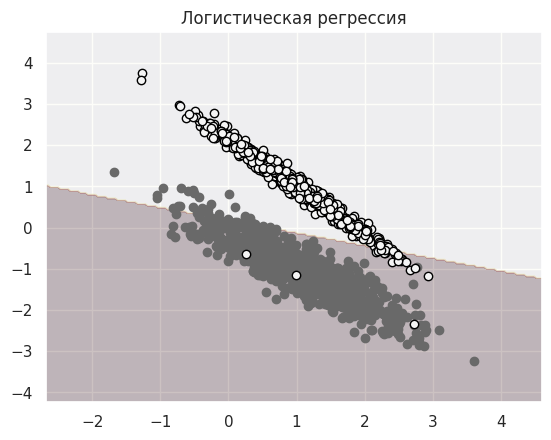

In [ ]:
model = Logit(0,0)
model.fit(X, y)
y[y == 0] = -1
plot_decision_boundary(model, X, y)

#### 5. [0.5 Балл] Для предыдущей задачи отобразите на графике, как изменяется значение функция потерь от номера итерации.

In [ ]:
def plot_loss_history(model):
    plt.plot(model.losses, label='Ошибка')
    plt.xlabel("Итерация")
    plt.ylabel("Ошибка")
    plt.legend()
    plt.show()

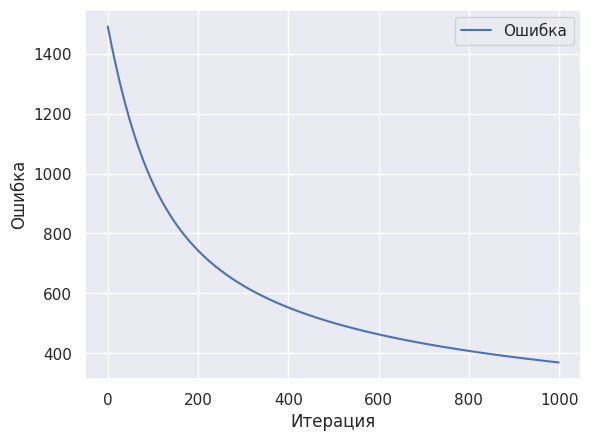

In [ ]:
plot_loss_history(model)

#### 6. [2 Балл] Для данных, на которых тестировали модель Логистической регрессии, заиспользуйте модель SVC из библиотеки sklearn. Попробуйте различные ядра (kernel) и различные коэфициенты C. Посмотрите на метрики, которые мы обсуждали на занятии (Acc, Precision, Recall, AUC-ROC, F1-Score).

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

def test_svc_models(X, y, test_size=0.3, random_state=42):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    kernels = ['linear', 'poly', 'rbf', 'sigmoid']
    C_values = [0.1, 1, 10, 100]
    results = []

    for kernel in kernels:
        for C in C_values:
            model = SVC(kernel=kernel, C=C, probability=True, random_state=random_state)
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            y_prob = model.predict_proba(X_test)[:, 1]

            accuracy = accuracy_score(y_test, y_pred)
            precision = precision_score(y_test, y_pred)
            recall = recall_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred)
            auc_roc = roc_auc_score(y_test, y_prob)

            results.append({
                'Kernel': kernel,
                'C': C,
                'Accuracy': accuracy,
                'Precision': precision,
                'Recall': recall,
                'F1-Score': f1,
                'AUC-ROC': auc_roc
            })

    return pd.DataFrame(results)


In [ ]:
df_results = test_svc_models(X, y)
print(df_results)

     Kernel      C  Accuracy  Precision    Recall  F1-Score   AUC-ROC
0    linear    0.1  0.994444   0.992395  0.996183  0.994286  0.998572
1    linear    1.0  0.994444   0.992395  0.996183  0.994286  0.998888
2    linear   10.0  0.994444   0.992395  0.996183  0.994286  0.998957
3    linear  100.0  0.994444   0.992395  0.996183  0.994286  0.998668
4      poly    0.1  0.994444   0.992395  0.996183  0.994286  0.993767
5      poly    1.0  0.994444   0.992395  0.996183  0.994286  0.994646
6      poly   10.0  0.994444   0.992395  0.996183  0.994286  0.994028
7      poly  100.0  0.994444   0.992395  0.996183  0.994286  0.994549
8       rbf    0.1  0.994444   0.992395  0.996183  0.994286  0.998902
9       rbf    1.0  0.994444   0.992395  0.996183  0.994286  0.998545
10      rbf   10.0  0.994444   0.992395  0.996183  0.994286  0.994961
11      rbf  100.0  0.994444   0.992395  0.996183  0.994286  0.992614
12  sigmoid    0.1  0.920370   0.881533  0.965649  0.921676  0.981314
13  sigmoid    1.0  

#### 7. [2 Балл] Реализуйте класс KNNClassifier, который должен реализовывать классификацию путем нахождения k ближайших соседей. В методе predict_proba Вам необходимо выдавать вектор вероятностей для каждого объекта, который означает, что объект является экземпляром i-го класса с p_i вероятностью. Протестируйте Ваш класс на данных, сгенерированных выше, посмотрите на метрики (Acc, Precision, Recall, AUC-ROC, F1-Score).

In [ ]:
from collections import Counter

class KNNClassifier:
    def __init__(self, n_neighbors=5):
        self.n_neighbors = n_neighbors

    def fit(self, X, y):
        self.X_train=X
        self.y_train=y

    def _calculate_distance(self, x1, x2):
        return np.sqrt(np.sum((x1-x2) ** 2))

    def _get_neighbors(self, x):
        distances = [(self._calculate_distance(x, x_train), y)
                     for x_train, y in zip(self.X_train, self.y_train)]
        sorted_distances = sorted(distances, key=lambda d: d[0])
        neighbors = sorted_distances[:self.n_neighbors]
        return neighbors

    def predict(self, X):
        predictions = []
        for x in X:
            neighbors = self._get_neighbors(x)
            labels = [label for _, label in neighbors]
            most_common = Counter(labels).most_common(1)[0][0]
            predictions.append(most_common)
        return np.array(predictions)

    def predict_proba(self, X):
        probabilities = []
        for x in X:
            neighbors = self._get_neighbors(x)
            labels = [label for _, label in neighbors]
            count = Counter(labels)
            total_neighbors = len(neighbors)
            proba = {label: count[label] / total_neighbors for label in set(self.y_train)}
            probabilities.append([proba.get(label, 0) for label in sorted(proba.keys())])
        return np.array(probabilities)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

knn = KNNClassifier()
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)
y_proba = knn.predict_proba(X_test)[:, 1]

accuracy = accuracy_score(y_test,y_pred)
precision = precision_score(y_test,y_pred,pos_label=1)
recall = recall_score(y_test,y_pred,pos_label=1)
f1 = f1_score(y_test,y_pred,pos_label=1)
auc_roc = roc_auc_score((y_test == 1).astype(int), y_proba)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"AUC-ROC: {auc_roc:.4f}")

Accuracy: 0.9944
Precision: 0.9924
Recall: 0.9962
F1-Score: 0.9943
AUC-ROC: 0.9944


## **Практическая часть**

В этом задании мы будем работать с Датасетом Fashion Mnist. Это датасет, который представляет изображения одного канала с различными типами одежды. Вам необходимо провести полный пайплайн обучения моделей (KNN и Logreg), которые вы можете импортировать из библиотеки sklearn.

#### 8. [0 Балл] Импортируйте датафрейм из csv файла. Поделите выборку следующим образом - :50000 (Train) и 50000: (Test).

In [ ]:
df = pd.read_csv("train.csv")

train = df[:50000]
test = df[50000:]


#### 9. [0.5 Балл] Визуализируйте некоторые из объектов датасета. В колонках отображены яркости пикселей, которые представляют из себя изображения Fashion Mnist. С помощью matplotlib визуализируйте по одному представителю каждого класса.

0 T-shirt/top
1 Trouser
2 Pullover
3 Dress
4 Coat
5 Sandal
6 Shirt
7 Sneaker
8 Bag
9 Ankle boot

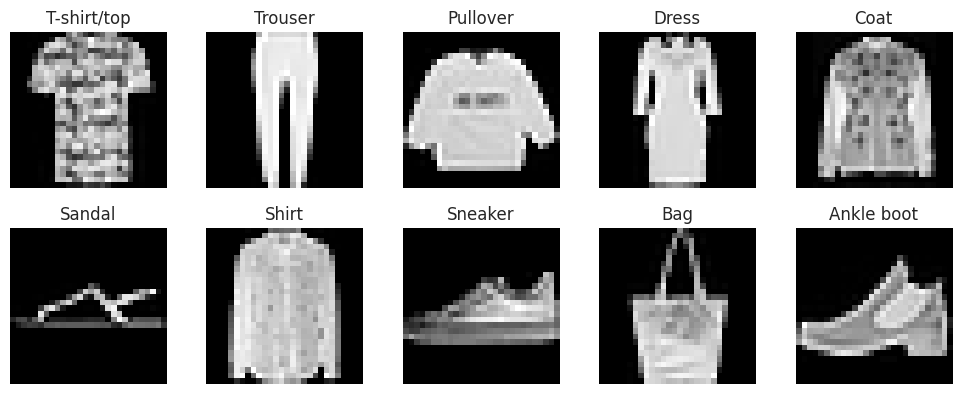

In [ ]:

labels = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
plt.figure(figsize=(10, 10))

for i in range(10):
    idx = train[train['Category']==i].index[0]
    image = train.iloc[idx, 2:].values.reshape(28, 28)

    plt.subplot(5, 5, i+1)
    plt.imshow(image, cmap='gray')
    plt.title(labels[i])
    plt.axis('off')

plt.tight_layout()
plt.show()

#### 10. [0.5 Балл] Отнормируйте признаки в датасете, попробуйте два варианта StandartScaller и MinMaxScaller.

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

def train_standard(X):
    standard_scaler = StandardScaler()
    X_standard = standard_scaler.fit(X).transform(X)
    return X_standard

def train_minmax(X):
    minmax_scaler = MinMaxScaler()
    X_minmax=minmax_scaler.fit(X).transform(X)
    return X_minmax


#### 10. [2 Балл] Проведите эксперименты: для моделей KNeighborsClassifier и LogisticRegression подберите гиперпараметры с помощью GridSerchCV (минимум 5 фолдов). Получите качество моделей на тестовой выборке. Основная метрика в данном задании будет accuracy. Сравните эти две модели. Какая модель показывает лучшее качество, предположите почему и напишите ответ.

**NB!**: в задании нужно подбирать несколько гиперпараметров по сетке. Какие гиперпараметры подбирать - решаете Вы сами. Обязательно обоснуйте, почему и какие параметры Вы подбираете! Например, подбор только гиперпараметра C в LogisticRegression не будет засчитываться как решение данного задания! Попытайтесь серьезно отнестись к нему, будто вы за это получите зарплату 300к.

## **Бонусы**

#### Задача 1. [1 Балл] У Вас есть датасет с 10**4 объектами. У всех объектов два признака и все они одинаковые у всех объектов. Однако, 5000 - отрицательного класса и 5000 - положительного класса. Вы запускате Логистическую регрессию для классификации на данном датасете. Что Вы получите в итоге обучения данной модели на SGD? Ответ обоснуйте.

#### Задача 2. [1 Балл] При классификации Fashion Mnist модель Логистической регрессии на обучении многоклассовой классификации методом One-VS-All у Вас получилось k классификаторов. Изобразите веса ваших полученных моделей как изображения в matplotlib. Возможно, модель выучила какие-то графические паттерны в данных? Ответ обоснуйте.

#### Задача 3. [1 Балл] В задаче классификации Fashion Mnist Вы попытались выбить какой-то accuracy. Для получения бонусного балла Вам нужно на той же самой выборке получить значение метрики accuracy > 0.87 на тесте (Тестовую выборку менять нельзя, но обучающую можно). Какими моделями и методами Вы это будете делать - на Ваше усмотрение, но **нельзя использовать никакие нейронные сети**. Необходимо получить модель машинного обучения, выполняющую эту задачу.